## Lecture 7

#### Goals

* Know the how and why of the MOPS feature descriptor
* Know how and why to match features using:
  * The SSD metric
  * The ratio test
* Be able to implement a barebones translational image alignment pipeline.

In [1]:
# boilerplate setup
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
import sys

src_path = os.path.abspath("../src")
if (src_path not in sys.path):
    sys.path.insert(0, src_path)

# Library imports
import numpy as np
import imageio.v3 as imageio
import matplotlib.pyplot as plt
import skimage as skim
import cv2

# codebase imports
import util
import filtering
import features
import geometry

#### Plan

* Feature matching: SSD, ratio distance
* Implement a barebones translational image alignment pipeline

### Inspirational Quote

>"Computer vision is a few good ideas glued together by a whole pile of hacks."
>
> -- Noah Snavely, computer vision researcher

### Panorama Stitching Overview

* Detect features
* Describe features
* Match features
* Estimate motion model
* Warp image(s) into common coordinate system and blend

#### Feature Matching

So you have a pile of feature descriptors across 2 images - how do we compare them?


## Brainstorm together

**Patches == Local Appearance**

How? 

Algorithms?

Pseudocode?

*Question:* how to define "how different" two patches are?

- sum of squared errors / differences
- access to color info? (important, but hard???)
- cross correlation?

*Question:* Computational efficiency. Uh oh. Just add more loops? :(

- hashes? keys? faster lookups? trying to avoid brute force.












Simplest metric choice: SSD = sum of squared differences (we used this in the Harris patch error metric)

$$ E(f, g) = \sum_{i=1}^d (f_i - g_i)^2$$

In [5]:
# implement ssd
# (solution in features.py:ssd)
def ssd(f, g):
    return np.sum(np.square(f - g))


Okay, we can compare 2 features; how do we find matches?

Simplest answer: brute force!

##### Homework Problems 1-2

In [2]:
F1 = np.array([
    [0, 1, 4, 3],
    [1, 0, 4, 1]], dtype=np.float32)

F2 = np.array([
    [2, 5, 1],
    [1, 5, 2]], dtype=np.float32)

##### Homework Problems 1-2
You can now do these with code or by hand:

1. Create a table with 4 rows and 3 columns in which the $(i,j)$th cell contains the SSD distance between feature $i$ in F1 and feature $j$ in F2.

2. For each feature in F1, give the **index** of the closest feature match in F2 using the SSD metric.

   *Note: The homework problem asks for 1-indexed indices, so don't forget to add 1 if you're coding this.*

In [6]:
d1, n1 = F1.shape
d2, n2 = F2.shape
print (F1.shape)
print(F2.shape)

distances = np.zeros((n1, n2))
for i in range(n1):
    for j in range(n2):
        patch1 = F1[:,i]
        patch2 = F2[:,j]
        distances[i,j] = ssd(patch1, patch2)
print(distances)
# TODO

(2, 4)
(2, 3)
[[ 4. 41.  2.]
 [ 2. 41.  4.]
 [13.  2. 13.]
 [ 1. 20.  5.]]


So, which patch matches are we buying?

Scheme: Patch 1.3 : image 1, third index patch

Smallest number in each row -> good
Smallest number in each col -> also good?

Decent matches:

P1.1 --> P2.3 * (2)
P1.2 --> P2.1   (2)
P1.3 --> P2.2 * (2)
P1.4 --> P2.1 * (1)

P2.1 --> P1.4 * (1)
P2.2 --> P1.3 * (2)
P2.3 --> P1.1 * (2)



Optimized brute force: [scipy.spatial.distance.cdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html) vectorizes the brute force for you; we're using the `sqeuclidean` distance.

You can get fancy by using spatial data structures like kd-trees, etc
* This is basically fast nearest neighbor search
* Fast approximate nearest neighbor search is also a big thing, but may not be great for us (you'll see why soon)



#### Algorithm to get a list of feature correspondences:
*  Algorithm:
  * foreach feature in 1
    * Take the closest feature in 2
   
Problem: the closest thing may not be very close

Solution: threshold! (?)

#### The Fence Strikes Back

![](../data/fences.jpg)


Insight: good matches are ones where the closest thing isn't just *barely* the closest thing.

Idea: look at the *second* closest match. Specifically, if $g_1$ and $g_2$ are the closest and second closest matches in image 2 to $f$ in image 1, then

$$
d_{\mathrm{ratio}} = \frac{SSD(f, g1)}{SSD(f, g2)}
$$

What does this equal if $g1$ and $g2$ are equally far from $f$?

How does it behave as $g_2$ gets increasingly far from $f$ compared to $g_1$? 


##### HW Problem 3
Again, you can do this by hand or with code:

```python
F1 =[0, 1, 4, 3],
    [1, 0, 4, 1]], dtype=np.float32)

F2 = np.array([
    [2, 5, 1],
    [1, 5, 2]], dtype=np.float32)
```

For each feature in F2, give the index of the closest feature match in F1 **and** the ratio distance between each feature and its closest match.


#### We have (almost all) the pieces

of an end-to-end image stitching pipeline. Two missing bits:

1. How do we model the motion between two images?

2. How do we get the images into a common coordinate system and blend them?


#### Bit 1:

For some simple cases (specifically: long focal length cameras), a very good approximation the motion from one image in a panorama sequence to another is a simple **translation**. That is, the image can be (pretty much) aligned by simply offseting all the pixels by some amount in $x$ and $y$.

**Brainstorm**: Given a list of feature correspondences, how could we estimate a single translation model that fits them as well as possible?

Sensible-seeming approach: average the displacements! If $(\mathbf{f}_i, \mathbf{g}_i)$ are corresponding feature pairs in image 1 and 2, then

$$\mathbf{t} = \frac{1}{n} \sum_{i=1}^n (\mathbf{f}_i - \mathbf{g}_i)$$

We'll return to this later and find that this not only seems sensible, but is in fact, a principled approach for a translational motion model.

#### Bit 2:

Build an affine transformation matrix and warp image 2 into an image that's large enough to fit its extent.

##### Homework Problems 4-5

4. Give a 3x3 affine transformation matrix that can be used to warp image 2 into image 1's coordinates.

5. If image 1's origin is at its top left and $t_x$ and $t_y$​ are both positive, what's the size of the destination image that can contain the combined image?



### Can we code this up in the time remaining?

(I have no idea whether this is doable, or if it will work well)

TODO:
* find Harris keypoints (use `features.harris_corners` then `features.get_harris_points`)
* extract descriptors (use `features.extract_MOPS`)
* implement `features.compute_distances` (use `features.ssd` and for loops, or use `scipy.spatial.distance.cdist`)
* implement `features.get_matches` to find closest matches and threshold by match score 
  * For SSD, `np.argmin` should do
  * For ratio distance, `np.argsort` is probably where it's at
* implement `geometry.estimate_translation` to average the differences between correspondences
* build an affine transformation matrix that applies that translation
* warp image 2 into a new image that's large enough to fit both (use `geometry.warp`)
* add (average? blend somehow?) image 1 into the warped image 2

If you get this working (i.e., running - it may not find a good model!), then try making it multi-scale:
* compute a Gaussian pyramid (implement `filtering.gaussian_pyramid`)
* adjust the above feature detection, extraction, and transformation estimation steps to account for multiple scales

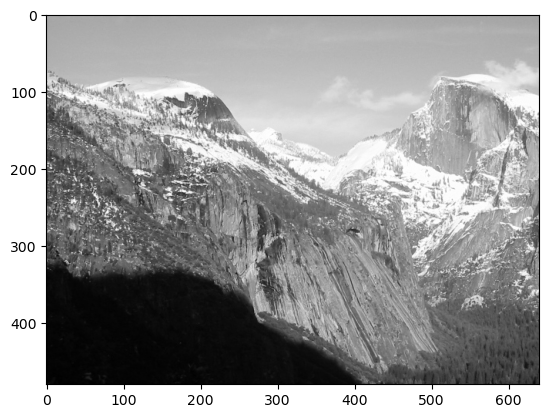

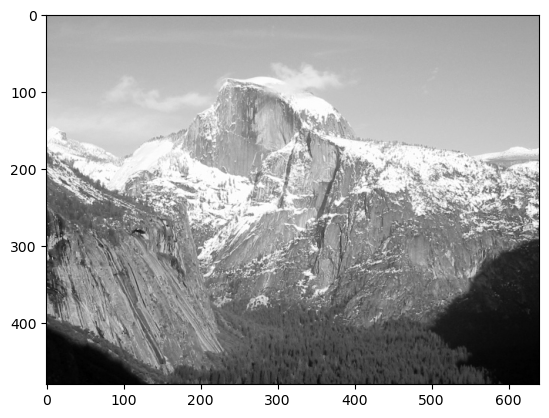

In [9]:
# here are two images where a translational alignment should work
y1 = imageio.imread("../data/yos1.jpg").astype(np.float32) / 255
y1 = skim.color.rgb2gray(y1)

y2 = imageio.imread("../data/yos2.jpg").astype(np.float32) / 255
y2 = skim.color.rgb2gray(y2)

util.imshow_gray(y1)
plt.show()
util.imshow_gray(y2)
plt.show()

In [32]:
def do_feature_detection(img, harris_threshold=0.80):
    # harris corners
    harris_mask = features.harris_corners(img, harris_threshold)
    harris_coords = features.get_harris_points(harris_mask)
    n = harris_coords.shape[1]
    
    print(f'found {n} harris corners')
    
    # create a big empty matrix for MOPS descriptors
    mops_descriptors = np.zeros((5, 5, n))
    grad = filtering.grad(img)

    # extract each MOPS descriptor. So slow.
    for i in range(n):
        print(f'extracting feature {i}')
        mops_descriptors[:,:,i] = features.extract_MOPS(img, harris_coords[:,i].flatten(), grad=grad)

    return harris_coords, mops_descriptors

In [33]:
y1_features, y1_descriptors = do_feature_detection(y1)
y2_features, y2_descriptors = do_feature_detection(y2)

found 53 harris corners
extracting feature 0
extracting feature 1
extracting feature 2
extracting feature 3
extracting feature 4
extracting feature 5
extracting feature 6
extracting feature 7
extracting feature 8
extracting feature 9
extracting feature 10
extracting feature 11
extracting feature 12
extracting feature 13
extracting feature 14
extracting feature 15
extracting feature 16
extracting feature 17
extracting feature 18
extracting feature 19
extracting feature 20
extracting feature 21
extracting feature 22
extracting feature 23
extracting feature 24
extracting feature 25
extracting feature 26
extracting feature 27
extracting feature 28
extracting feature 29
extracting feature 30
extracting feature 31
extracting feature 32
extracting feature 33
extracting feature 34
extracting feature 35
extracting feature 36
extracting feature 37
extracting feature 38
extracting feature 39
extracting feature 40
extracting feature 41
extracting feature 42
extracting feature 43
extracting feature

In [34]:
print(y1_features.shape)
print(y1_descriptors.shape)
print(y2_features.shape)
print(y2_descriptors.shape)

(2, 53)
(5, 5, 53)
(2, 17)
(5, 5, 17)


In [35]:
# Next task: compute all pairwise distances
n1 = y1_features.shape[1]
n2 = y2_features.shape[1]
ssd_matrix = np.zeros((n1, n2))
for i in range(n1):
    for j in range(n2):
        ssd_matrix[i,j] = ssd(y1_descriptors[:,:,i], y2_descriptors[:,:,j])

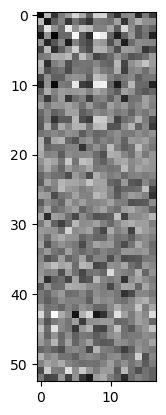

In [37]:
# rough visualization
plt.imshow(ssd_matrix, cmap='grey')
plt.show()